# Predicting Knowledge Level of Students in Electrical DC Machines
By: Carson, Manjot, Qiancheng, and Yichen

# Introduction

This project aims to analyze students' knowledge of Electrical DC Machines, which are crucial components of many electrical systems. The dataset is from a Ph.D. thesis on the UCI Machine Learning Repository titled "User knowledge Modelling Data Set."

We want to answer the following question:

**Can we predict the knowledge level of students in Electrical DC Machines given the factors listed below?**

The columns in the dataset (taken mainly from the dataset description) are:
<ol>
    <li> STG: The degree of study time for goal object materials </li>
    <li> SCG: The degree of repetition number of users for goal materials</li>
    <li> STR: The degree of study time of users for related objects with goal object</li>
    <li> LPR: The exam performance of users for related objects with goal object </li>
    <li> PEG: The exam performance of users for goal objects</li>
    <li> UNS: The knowledge level of users (with 4 values: *Very Low*, *Low*, *Middle*, and *High*)</li>
</ol>

**Note**: all numerical data is standardized, and "goal object" refers to the subject of Electrical DC Machines while "related objects with goal object" refer to the other subjects or topics that are related but not exactly the "goal object".

# Preliminary exploratory data analysis

In [16]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(readxl)
library(GGally)
install.packages("themis")
library(themis)
set.seed(1234)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



<h2> Loading the dataset into R </h2>

In [17]:
temp_file <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", temp_file)
study_data <- read_excel(temp_file, sheet = 2)
# study_data <- read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", sheet = 2)
head(study_data)

New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)


<h2> Cleaning and Wrangling </h2>

In [18]:
set.seed(1234)
#Data is already in tidy format
study_data_required <- study_data |> select(STG,SCG,STR,LPR,PEG,UNS) |> drop_na() # selecting all of the columsn and removing the columns with no values
head(study_data_required) # Preview of the ENTIRE dataset

#Summarizing
nrow(study_data_required) # Number of rows
data_split <- initial_split(study_data_required,prop = 0.75, strata = UNS) # Splitting our data 75% for training, 25% for testing
data_training <- training(data_split)
data_test <- testing(data_split)

head(data_training) # Preview of Training data
head(data_test) # Preview of Testing data

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


[1] 258

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.000,0.50,0.20,0.85,High
0.18,0.180,0.55,0.30,0.81,High
0.12,0.120,0.75,0.35,0.80,High
0.05,0.070,0.70,0.01,0.05,very_low
0.09,0.300,0.68,0.18,0.85,High
0.08,0.325,0.62,0.94,0.56,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.20,0.14,0.35,0.72,0.25,Low
0.10,0.10,0.70,0.15,0.90,High
0.20,0.20,0.70,0.30,0.60,Middle
0.18,0.31,0.32,0.42,0.28,Low


<h2> Summary of the Dataset (not using Training dataset)</h2>

In [19]:
num_obs <- nrow(study_data_required)

data_summary <- study_data_required |>
  group_by(UNS) |>
  summarize(
    count = n(),
    percentage = (n()/num_obs) * 100
  )

data_summary # Gives preview of ALL the data we have

UNS,count,percentage
<chr>,<int>,<dbl>
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527
very_low,24,9.302326


Table 1: Total UNS counts

<h2>Summary of the data using Training Data </h2>

In [20]:
num_observation <- nrow(data_training)

data_summary_train <- data_training |>
  group_by(UNS) |>
  summarize(
    count = n(),
       percentage = (n()/num_observation) * 100,
       STG_mean = mean(STG, na.rm = TRUE),
       SCG_mean = mean(SCG, na.rm = TRUE),
       STR_mean = mean(SCG, na.rm = TRUE),
       LPR_mean = mean(LPR, na.rm = TRUE),
       PEG_mean = mean(PEG, na.rm = TRUE))

data_summary_train

UNS,count,percentage,STG_mean,SCG_mean,STR_mean,LPR_mean,PEG_mean
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,48,25.000000,0.4100000,0.4216875,0.4216875,0.4914583,0.7725000
Low,62,32.291667,0.3170806,0.3367097,0.3367097,0.4932258,0.2360161
Middle,68,35.416667,0.3883529,0.3709265,0.3709265,0.3310294,0.5470588
very_low,14,7.291667,0.3337857,0.2164286,0.2164286,0.3350000,0.1064286


Table 2: Total UNS counts with averages

In [21]:
# Wrangling the data, removing count and percentage and turning the columns into rows
data_mean <- data_summary_train |>
    select(-count, -percentage) |>
    pivot_longer(cols = c(STG_mean, SCG_mean, STR_mean, LPR_mean, PEG_mean),
                 names_to = "score", # temporary name for both exam score and study habit score
                 values_to = "mean") |>
    mutate(UNS = factor(UNS, levels = c("very_low", "Low", "Middle", "High"))) |>
    arrange(UNS)

In [45]:
# Code for study habits vs. Knowledge level plot
study_habit_means <- data_mean |>
    filter(score != 'LPR_mean' & score != 'PEG_mean') |>
    rename(study_habit = score)

study_habits_means_vs_knowledge_plot <- ggplot(study_habit_means, aes(x = UNS, y = mean, fill = study_habit)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(cols = vars(study_habit)) +  
    labs(x = "Knowledge Level of User", y = "Study Habits", fill = "Study Habit") +
    ggtitle("Study Habits vs Knowledge Level of User")+theme(text=element_text(size=20))

In [46]:
# Code for exam performance vs. Knowledge level plot
exam_performance_means <- data_mean |>
    filter(score == 'LPR_mean' | score == 'PEG_mean') |>
    rename(exam_performance = score)

exam_performance_means_vs_knowledge_plot <- ggplot(exam_performance_means, aes(x = UNS, y = mean, fill = exam_performance)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(cols = vars(exam_performance)) +  
    labs(x = "Knowledge Level of User", y = "Exam Performance", fill = "Exam Performance") +
    ggtitle("Exam Performance vs Knowledge Level of User")

In [47]:
# Plots
options(repr.plot.width = 20, repr.plot.height = 9)

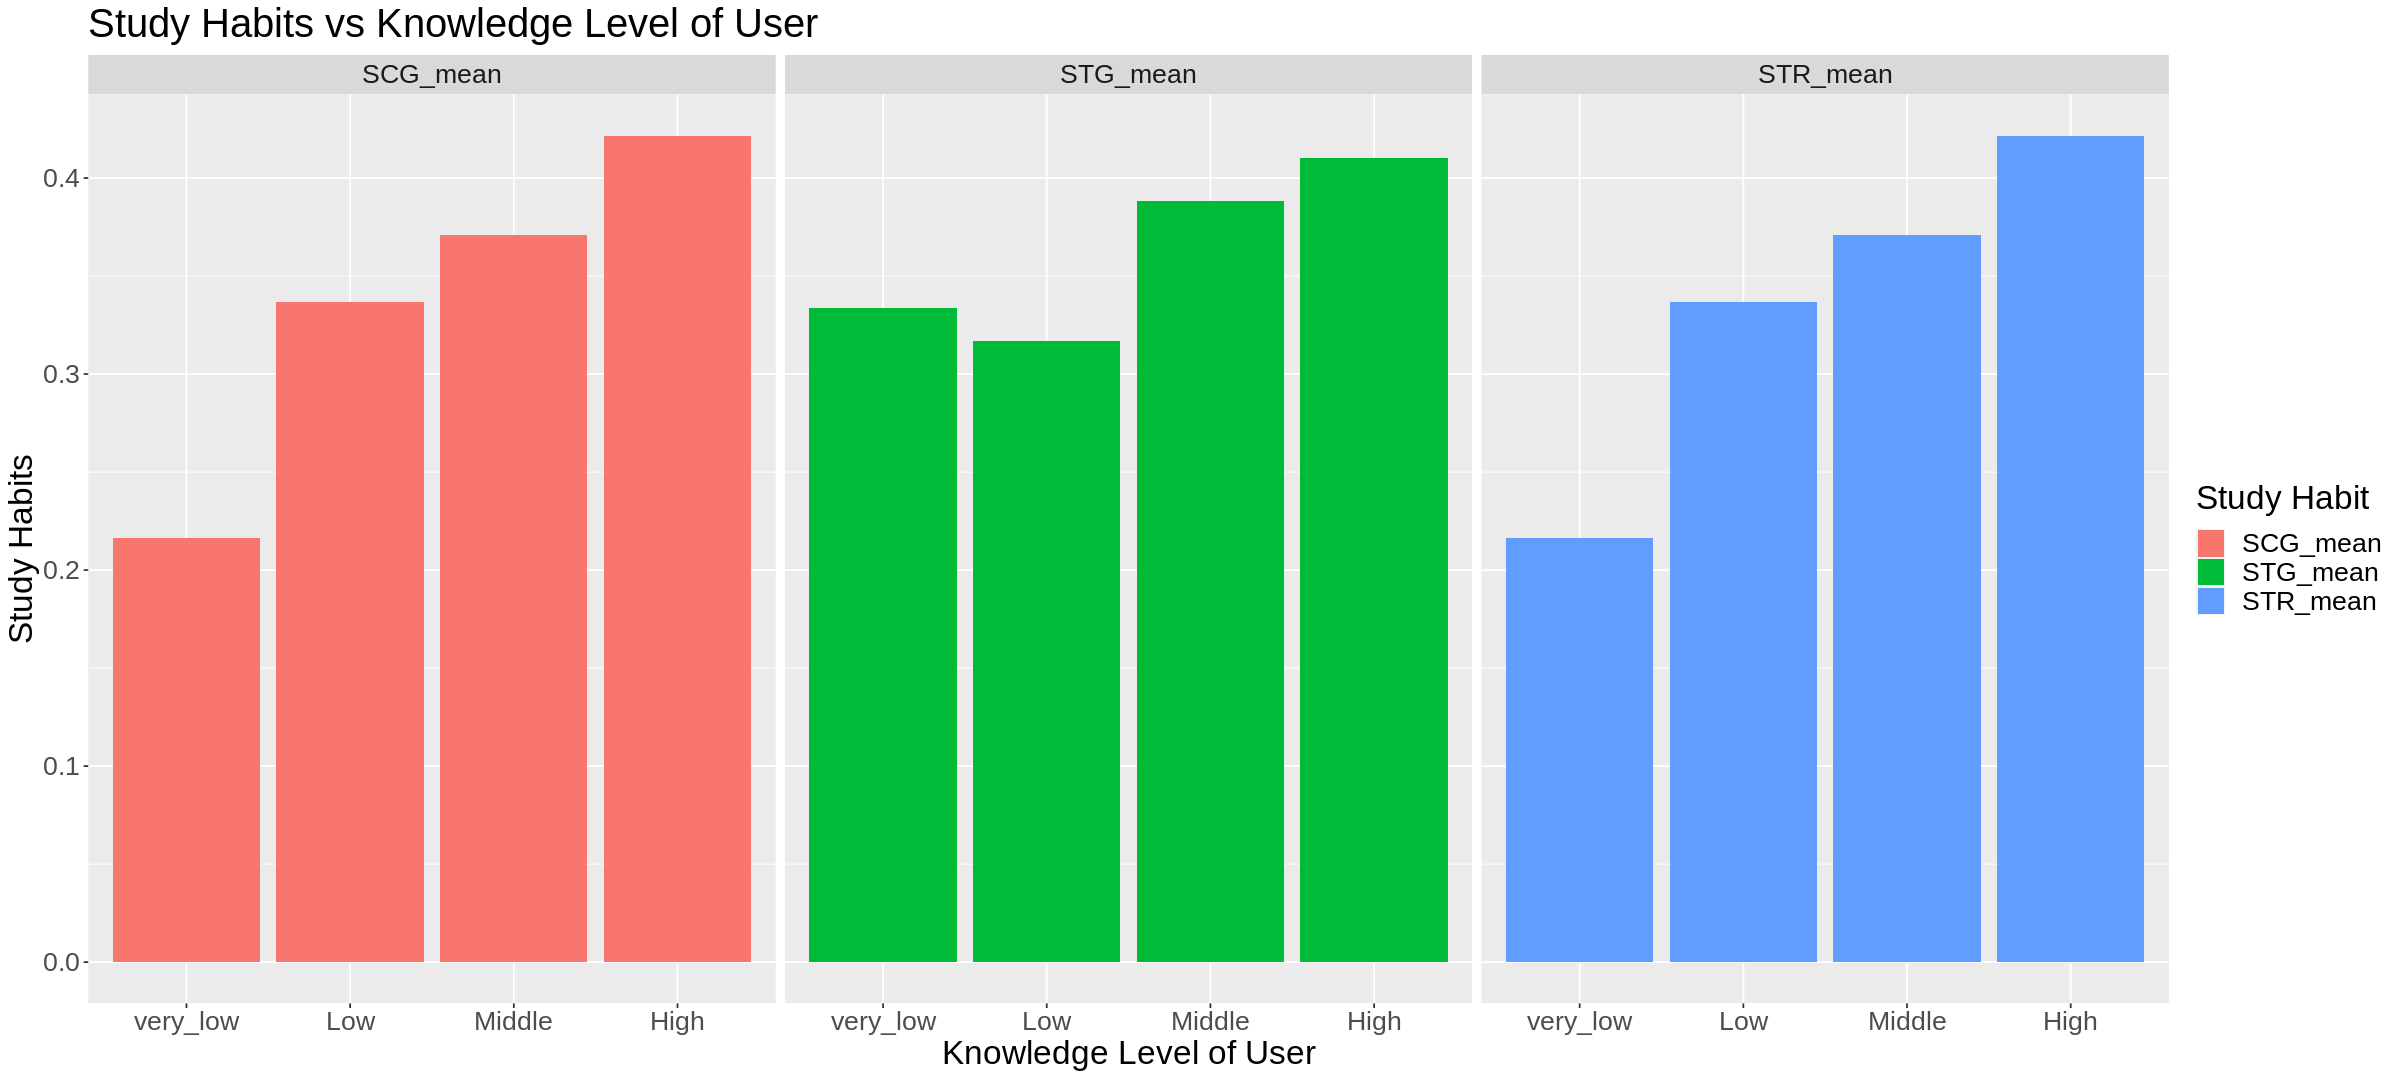

In [48]:
study_habits_means_vs_knowledge_plot

Figure 1: Study Habits vs Knowledge of Level of User

#### Interpretation of Figure 1
We can see that SCG and STR are positively correlated with study habits, that is that the higher the study habit results in higher level of knowledge. However, for STG, we can see that very low knowledge actually has a higher study habits.

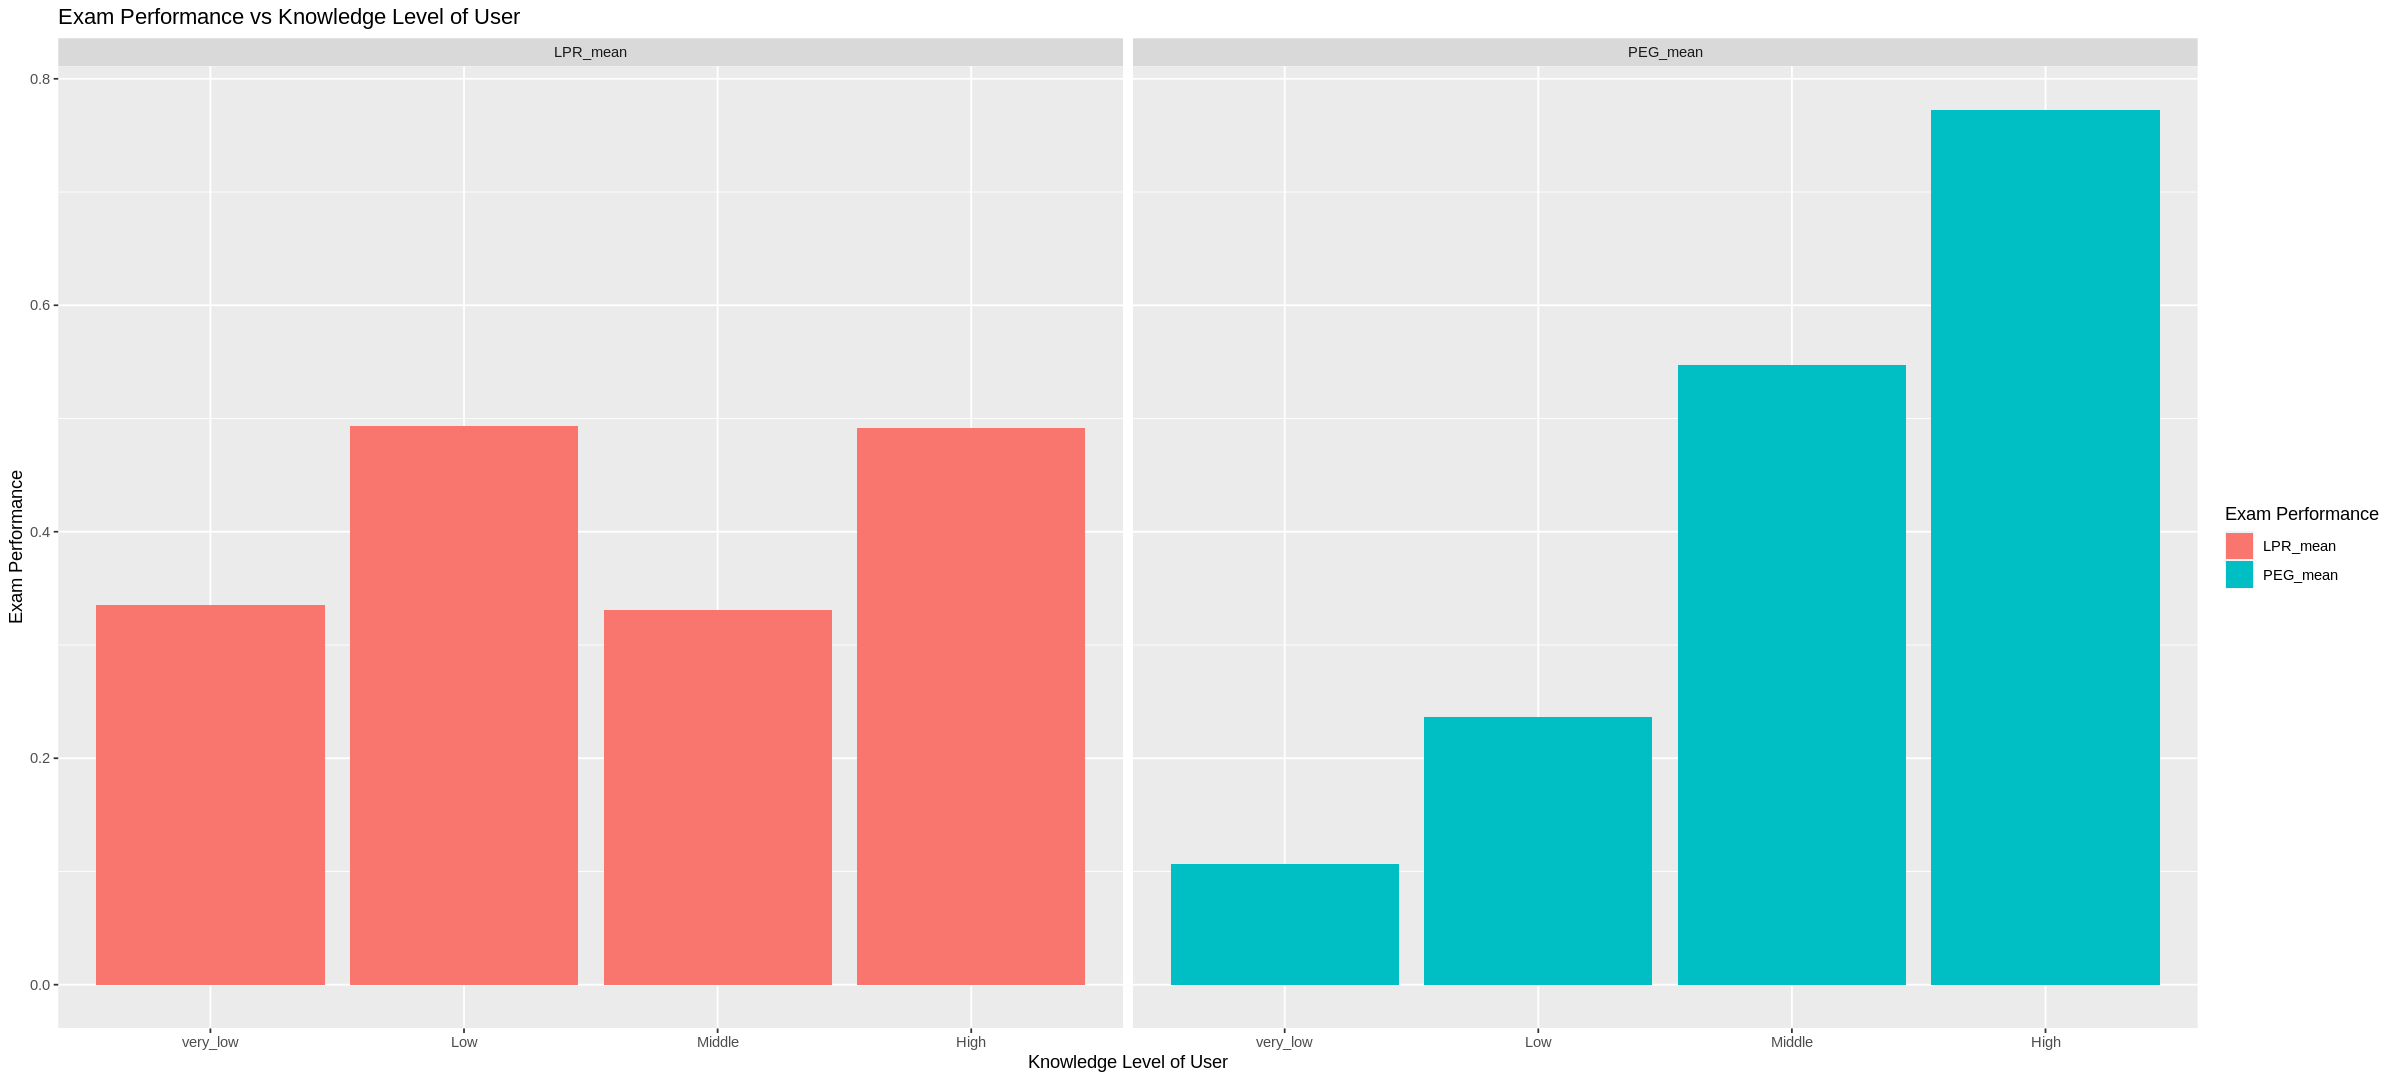

In [26]:
exam_performance_means_vs_knowledge_plot

Figure 2: Exam performance vs Knowledge Level of user

#### Interpretation of Figure 1
Notice that PEG is strongly positively correlated with knowledge level while LPR is not, this means that, when using these for predictors, LPR would not be a good one as if we had a high exam performance score, we would not have a good estimate of whether or not a user has a Low/High knowledge level while with PEG we can easily predict this.

<h2>Data Analysis </h2>

In [27]:
set.seed(1234)

data_training <- data_training |> 
    mutate(UNS = as_factor(UNS))

# Start by balancing our data since we saw earlier that it is not very balanced
upsampled_data_training <- recipe(UNS ~ SCG + STR + PEG, data = data_training) |>
    step_upsample(UNS, over_ratio = 1, skip = FALSE) |>
    prep() |>
    bake(data_training)

upsampled_data_training_count <- upsampled_data_training |>
    group_by(UNS) |>
    summarize(n = n())
upsampled_data_training_count

UNS,n
<fct>,<int>
High,68
very_low,68
Low,68
Middle,68


Table 3: Balanced training data

In [28]:
# Fixing testing data for later
# Only selecting the columns we are predicting
data_test <- data_test |>
    select(UNS, SCG, STR, PEG) |>
    mutate(UNS = as_factor(UNS))

# Making sure testing and training data has the proper levels
uns_factors <- c("very_low", "Low", "Middle", "High")
data_test$UNS <- factor(data_test$UNS, levels = uns_factors)
upsampled_data_training$UNS <- factor(upsampled_data_training$UNS, levels = uns_factors)

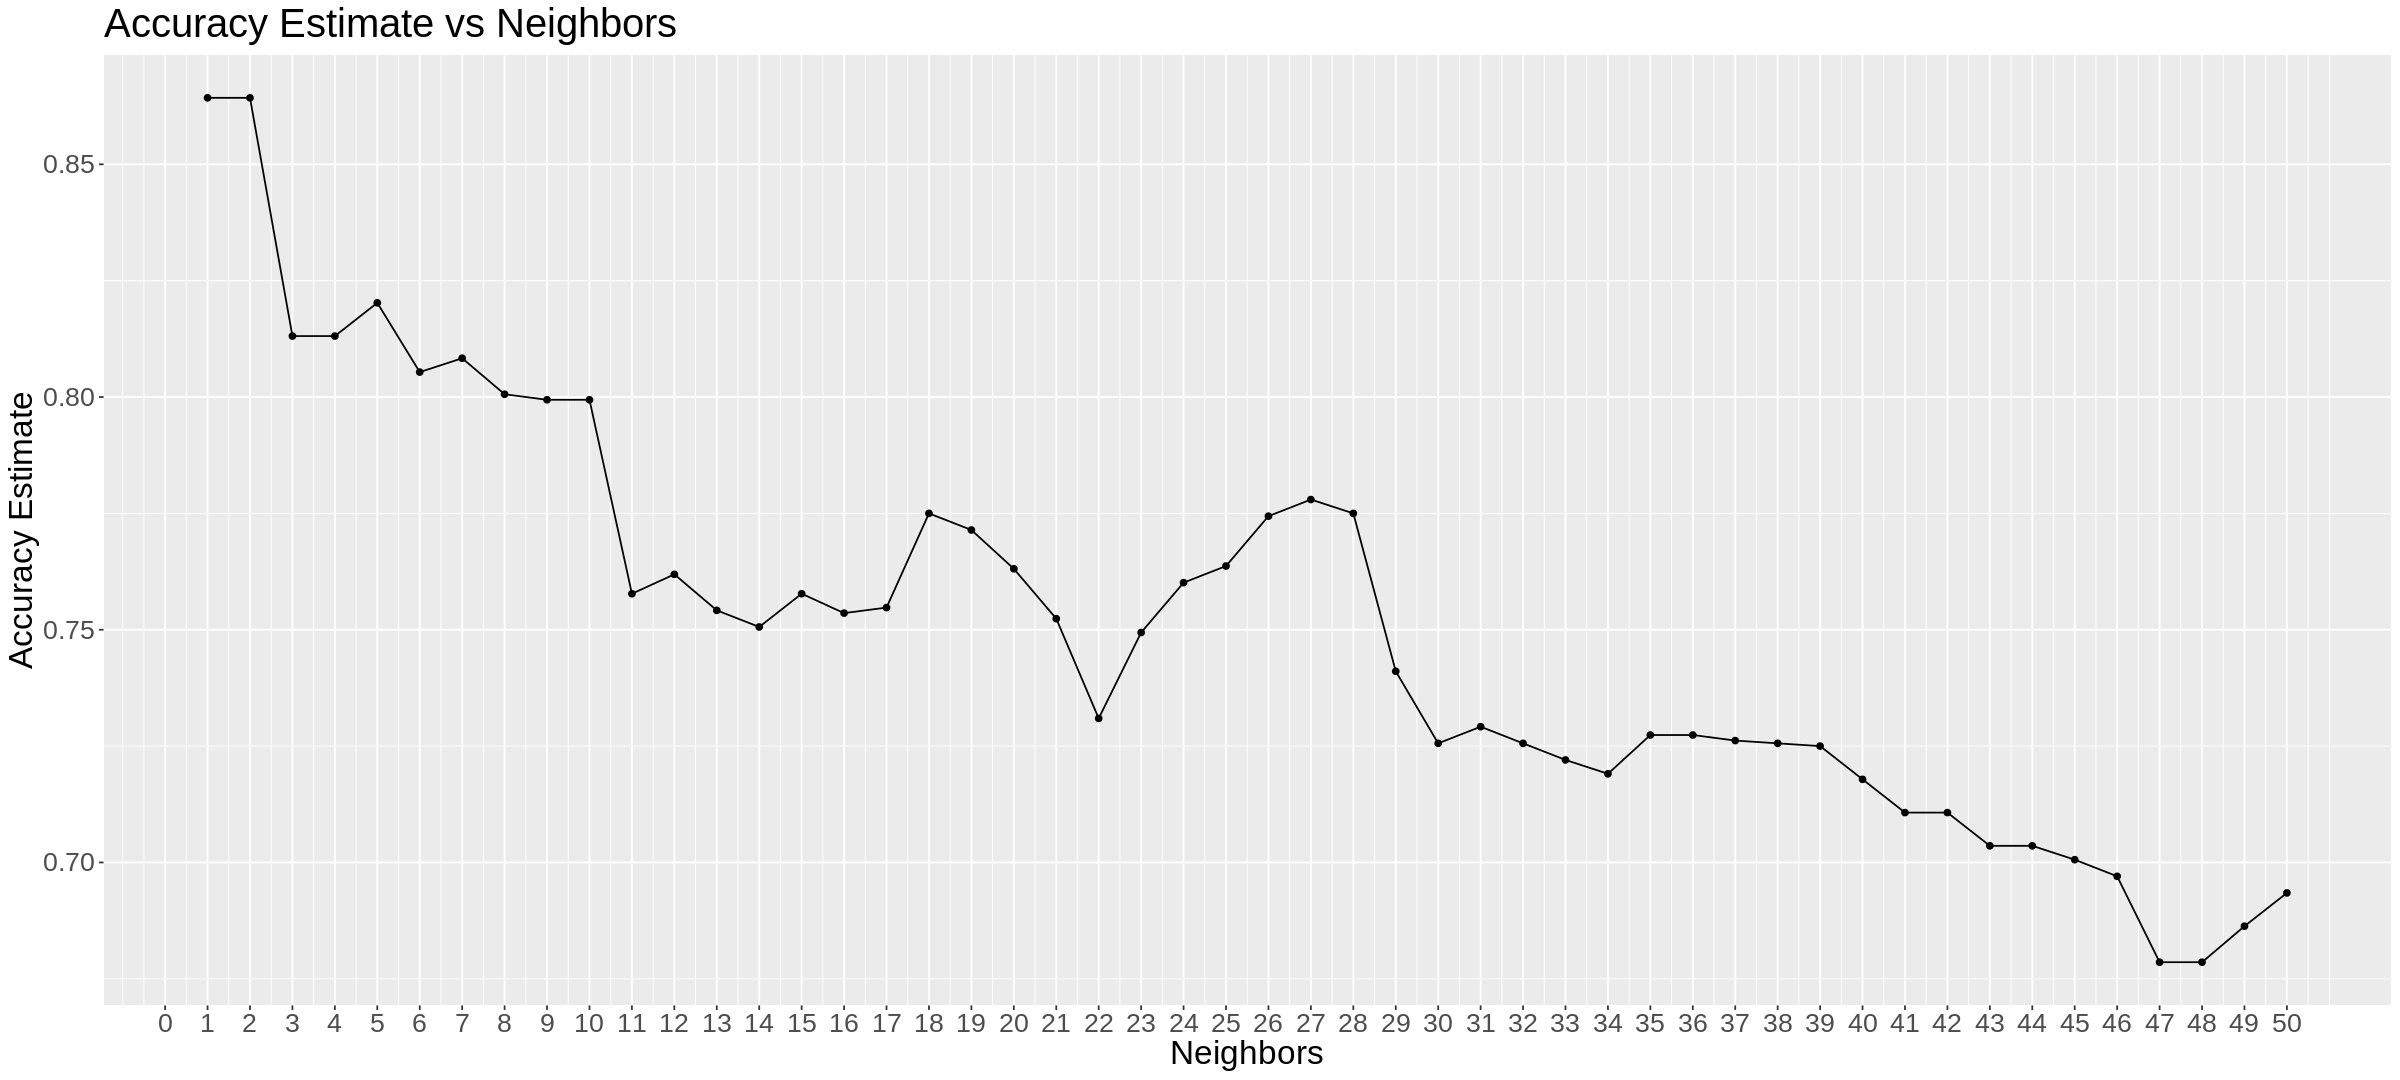

In [29]:
set.seed(1234)

# Performing 10 fold cross validation and testing neighbors with values 1 through 50
vfold <- vfold_cv(upsampled_data_training, v = 10, strata = UNS)
gridvals = tibble(neighbors = seq(1:50))

# knn recipe
knn_recipe <- recipe(UNS ~ SCG + STR + PEG, data = upsampled_data_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# knn spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# knn results
knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# Plotting knn to see best k value
cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))+
    scale_x_continuous(breaks = seq(0, 50, by = 1)) +
    ggtitle("Accuracy Estimate vs Neighbors")
cross_val_plot

Figure 3: KNN values

In [30]:
# Obtaining the k value that gives us the best accuracy
min_k_value <- knn_results |>
    slice(which.max(mean)) |>
    select(neighbors)
min_k_value

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = min_k_value) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = upsampled_data_training)

neighbors
<int>
1


In [31]:
# Predicting
knn_predictions <- predict(knn_fit, data_test) |> 
    bind_cols(data_test)

# Calculating accuracy
knn_acc <- knn_predictions |> 
    metrics(truth = UNS, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
knn_acc

knn_conf_mat <- knn_predictions |> 
    conf_mat(truth = UNS, estimate = .pred_class)
knn_conf_mat

.metric,.estimate
<chr>,<dbl>
accuracy,0.6666667


          Truth
Prediction very_low Low Middle High
  very_low        7   3      0    0
  Low             3  14      3    0
  Middle          0   4     16    8
  High            0   0      1    7

# Methods

We will conduct our data analysis by investigating the following columns: we will be using SCG, STR, and PEG (meanings were discussed above) since these show a relationship between them and UNS, specifically that the higher average values often resulted in a high level of knowledge (shown in the visualization above). Bar plots were used to compare UNS with each study habit because this is a simple way to 

We will use the classification by the k-nearest neighbor method, evaluating and tuning the classifier to predict UNS based on our 3 predictor columns.

We will visualize the results by plotting each of the study habits used in our classifier (SCG and STR) against PEG and then coloring by UNS to help identify patterns of UNS and where they occur with respect to these predictors.

# Expected outcomes and significance

### What do you expect to find?

From the above plot and summary analysis, we can loosely infer that the knowledge level of the user is highly dependent on the time allotted for the study, repetitions of the material, study time for the particular topic, and exam performance for goal objects. We expect that users with study habits and exam performance on the main subject of study, which was on the higher scale, might fall on a high knowledge level, while students' lower values resulted in low levels of knowledge.

### What impact could such findings have?

The findings of this analysis could help to identify knowledge gaps among students in Electrical DC Machines. By analyzing the relationship between study habits, exam performance, and knowledge level, educators and trainers can identify which specific areas of Electrical DC Machines cause the most difficulties for students. With this information, they can develop targeted strategies to address these knowledge gaps and improve overall learning outcomes.

<h3>What future questions could this lead to? </h3>

- How can educators use this information to design more effective learning strategies for individual students?

- Are there other factors, such as student motivation or learning style, that also play a significant role in predicting user knowledge level? 

- What can be the potential further effects of knowledge level?

# Reference 

H. T. Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and modeling of users' domain dependent data in web,
Knowledge Based Systems, vol. 37, pp. 283-295, 2013.